In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Literal, Tuple
import re
import mteb
import os
import json

In [56]:
def extract_number(s):
    m = re.search(r'\d+', s)
    return int(m.group()) if m else float('inf')

In [57]:
def get_task_type(task_name):
    task = mteb.get_tasks(tasks=[task_name])[0]
    return task.metadata.type

In [58]:
def find_highest_score(df: pd.DataFrame) -> tuple[str, float]:
    max_index = df.iloc[:, 1].idxmax()
    max_score = df.iloc[:, 1].max()
    corresponding_string = df.iloc[max_index, 0]
    return corresponding_string, max_score

In [59]:
def find_highest_score(
    df: pd.DataFrame,
    filter_by: Literal['epoch', 'step', 'both'] = 'both'
) -> Tuple[str, float]:
    """
    Return the label and value of the highest score in column 1,
    optionally filtering to only 'epoch_*' or 'step_*' rows.

    Parameters
    ----------
    df : pd.DataFrame
        Two-column DataFrame where
        - col 0 contains strings like 'epoch_1', 'step_38', etc.
        - col 1 contains numeric scores.
    filter_by : {'epoch', 'step', 'both'}
        What to include in the search:
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering (default)

    Returns
    -------
    label : str
        The string (from col 0) corresponding to the highest score.
    max_score : float
        The highest score found in col 1.
    """
    if filter_by == 'epoch':
        mask = df.iloc[:, 0].str.startswith('epoch_')
    elif filter_by == 'step':
        mask = df.iloc[:, 0].str.startswith('step_')
    elif filter_by == 'both':
        mask = pd.Series(True, index=df.index)
    else:
        raise ValueError(f"filter_by must be 'epoch', 'step' or 'both'; got {filter_by!r}")

    filtered = df.loc[mask]

    if filtered.empty:
        raise ValueError(f"No rows matched filter '{filter_by}'")

    max_idx = filtered.iloc[:, 1].idxmax()
    max_score = filtered.iloc[:, 1].max()
    label = df.at[max_idx, df.columns[0]]

    return label, max_score

In [60]:
def find_highest_score(
    df: pd.DataFrame,
    filter_by: Literal['epoch', 'step', 'both'] = 'both'
) -> Tuple[str, float]:
    """
    Return the label and value of the highest score in column 'score',
    optionally filtering by 'epoch_' or 'step_' prefixes—but if no such
    labels exist, fall back to considering all rows.

    Parameters
    ----------
    df : pd.DataFrame
        A two-column DataFrame where
        - the first column is some kind of label (string),
        - the second column is the score (float).
        It may or may not have headers.
    filter_by : {'epoch', 'step', 'both'}
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering

    Returns
    -------
    label : str
        The label for the highest-scoring row.
    max_score : float
        That highest score.

    Raises
    ------
    ValueError
        If after filtering there are no rows at all.
    """

    df = df.rename(columns={df.columns[0]: "label", df.columns[1]: "score"})

    # 2) Build our mask
    if filter_by in ('epoch', 'step'):
        prefix = f"{filter_by}_"
        mask = df['label'].str.startswith(prefix)
        if not mask.any():
            # fallback: no matching labels, so we just consider everything
            mask = pd.Series(True, index=df.index)
    elif filter_by == 'both':
        mask = pd.Series(True, index=df.index)
    else:
        raise ValueError(f"filter_by must be 'epoch', 'step' or 'both'; got {filter_by!r}")

    filtered = df.loc[mask]
    if filtered.empty:
        raise ValueError(f"No rows found after applying filter '{filter_by}'")

    # 3) Find the max
    max_idx = filtered['score'].idxmax()
    return df.at[max_idx, 'label'], df.at[max_idx, 'score']

In [61]:
def best_run_mean_score(path: str, filter_by: Literal['epoch', 'step', 'both'] = 'both') -> pd.DataFrame:
    """
    Iterate over subdirectories of the given path. For each experiment,
    if mean_scores.csv exists, load it and find the highest score using find_highest_score.
    Returns a DataFrame with experiment names as index and their best scores.

    Parameters
    ----------
    path : str
        Path to directory containing experiment folders
    filter_by : {'epoch', 'step', 'both'}
        What to include in the search:
        - 'epoch': only rows whose label starts with 'epoch_'
        - 'step' : only rows whose label starts with 'step_'
        - 'both' : no filtering (default)

    Returns
    -------
    pd.DataFrame
        DataFrame with experiment names as index and columns 'step' and 'score'
    """
    results = []

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            means_file = os.path.join(folder_path, "mean_scores.csv")
            if os.path.isfile(means_file):
                # Read the mean scores file and determine the best run
                mean_df = pd.read_csv(means_file)
                step, score = find_highest_score(mean_df, filter_by)
                new_path = os.path.join(folder_path,step,os.listdir(os.path.join(folder_path,step))[0])
                chem_ret_scores_path = os.path.join(new_path,"ChemRxivRetrieval.json")
                meta_data_path = os.path.join(new_path,"model_meta.json")
                if not os.path.isfile(chem_ret_scores_path):
                    chem_ret_scores_path = os.path.join(new_path,"ChemRxivNC2.json")
                if os.path.isfile(chem_ret_scores_path) and os.path.isfile(meta_data_path):
                    with open(chem_ret_scores_path, 'r',encoding='utf-8') as f:
                        chem_ret_scores = json.load(f)

                    with open(meta_data_path, 'r',encoding='utf-8') as f:
                        meta_data = json.load(f)
                else:
                    print(f"Missing files in {folder_path}: {chem_ret_scores_path} or {meta_data_path}")
                    continue        
                results.append({
                    "exp": folder,
                    "step": step,
                    "embeding_dim": meta_data["embed_dim"],
                    "n_parameters" : meta_data["n_parameters"],
                    "evaluation_time":  chem_ret_scores['evaluation_time'],
                    'mapat10':chem_ret_scores['scores']['test'][0]['map_at_10'],
                    'mrrat10': chem_ret_scores['scores']['test'][0]['mrr_at_10'],
                    'ndcgat10': chem_ret_scores['scores']['test'][0]['ndcg_at_10'],
                    "score": score,

                })
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        results_df.set_index("exp", inplace=True)
    return results_df.sort_index(key=lambda x: x.map(extract_number))

In [62]:
best_df = best_run_mean_score('ChemRxivRetrieval', 'epoch')

In [63]:
best_df

,step,embeding_dim,n_parameters,evaluation_time,mapat10,mrrat10,ndcgat10,score
exp,,,,,,,,
nomic-ai__nomic-embed-text-v1-unsupervised,nomic-ai__nomic-embed-text-v1-unsupervised,768,136731648.0,398.103216,0.77338,0.773909,0.81445,0.81445
bedrock__amazon-titan-embed-text-v1,bedrock__amazon-titan-embed-text-v1,1536,NaN,4243.291113,0.61052,0.610754,0.66495,0.66495
BAAI__bge-small-en-v1.5,BAAI__bge-small-en-v1.5,384,33360000.0,127.575564,0.67215,0.672109,0.71868,0.71868
multi-qa-mpnet-base-dot-v1,multi-qa-mpnet-base-dot-v1,768,109486464.0,344.766183,0.69722,0.697105,0.74083,0.74083
BAAI__bge-large-en-v1.5,BAAI__bge-large-en-v1.5,1024,335141888.0,871.428537,0.71682,0.717309,0.76281,0.76281
...,...,...,...,...,...,...,...,...
answerdotai__ModernBERT-large,answerdotai__ModernBERT-large,1024,394781696.0,799.738114,0.04878,0.048768,0.05787,0.05787
answerdotai__ModernBERT-base,answerdotai__ModernBERT-base,768,149014272.0,310.362468,0.04754,0.047541,0.05556,0.05556
allenai__scibert_scivocab_uncased,allenai__scibert_scivocab_uncased,768,109918464.0,249.135083,0.10061,0.100522,0.11885,0.11885


In [64]:
best_df = best_df.reset_index().rename(columns={'index': 'exp'})


In [65]:
best_df

,exp,step,embeding_dim,n_parameters,evaluation_time,mapat10,mrrat10,ndcgat10,score
0,nomic-ai__nomic-embed-text-v1-unsupervised,nomic-ai__nomic-embed-text-v1-unsupervised,768,136731648.0,398.103216,0.77338,0.773909,0.81445,0.81445
1,bedrock__amazon-titan-embed-text-v1,bedrock__amazon-titan-embed-text-v1,1536,NaN,4243.291113,0.61052,0.610754,0.66495,0.66495
2,BAAI__bge-small-en-v1.5,BAAI__bge-small-en-v1.5,384,33360000.0,127.575564,0.67215,0.672109,0.71868,0.71868
3,multi-qa-mpnet-base-dot-v1,multi-qa-mpnet-base-dot-v1,768,109486464.0,344.766183,0.69722,0.697105,0.74083,0.74083
4,BAAI__bge-large-en-v1.5,BAAI__bge-large-en-v1.5,1024,335141888.0,871.428537,0.71682,0.717309,0.76281,0.76281
...,...,...,...,...,...,...,...,...,...
64,answerdotai__ModernBERT-large,answerdotai__ModernBERT-large,1024,394781696.0,799.738114,0.04878,0.048768,0.05787,0.05787
65,answerdotai__ModernBERT-base,answerdotai__ModernBERT-base,768,149014272.0,310.362468,0.04754,0.047541,0.05556,0.05556
66,allenai__scibert_scivocab_uncased,allenai__scibert_scivocab_uncased,768,109918464.0,249.135083,0.10061,0.100522,0.11885,0.11885
67,recobo__chemical-bert-uncased,recobo__chemical-bert-uncased,768,109918464.0,267.049641,0.09588,0.095894,0.11039,0.11039


In [66]:
col = 'exp'

mask_drop = (
    best_df[col].str.startswith('run', na=False) & 
    ~best_df[col].str.startswith(('run15', 'run22','run23','run24'), na=False) 
)

best_df_filtered = best_df[~mask_drop].copy()
best_df_filtered['exp'] = best_df_filtered['exp'].replace({'run15-chemical-finetune-pair': 'ChemEmbed (BERT tokenizer)'})
best_df_filtered['exp'] = best_df_filtered['exp'].replace({'run24-chemical-finetune-pair': 'ChemEmbed (all trainable)'})
best_df_filtered['exp'] = best_df_filtered['exp'].replace({'run22-chemical-finetune-pair': 'ChemEmbed (unused+rest)'})
best_df_filtered['exp'] = best_df_filtered['exp'].replace({'run23-chemical-finetune-pair': 'ChemEmbed (progressive)'})


In [67]:
best_df_filtered

,exp,step,embeding_dim,n_parameters,evaluation_time,mapat10,mrrat10,ndcgat10,score
0,nomic-ai__nomic-embed-text-v1-unsupervised,nomic-ai__nomic-embed-text-v1-unsupervised,768,1.367316e+08,398.103216,0.77338,0.773909,0.81445,0.81445
1,bedrock__amazon-titan-embed-text-v1,bedrock__amazon-titan-embed-text-v1,1536,NaN,4243.291113,0.61052,0.610754,0.66495,0.66495
2,BAAI__bge-small-en-v1.5,BAAI__bge-small-en-v1.5,384,3.336000e+07,127.575564,0.67215,0.672109,0.71868,0.71868
3,multi-qa-mpnet-base-dot-v1,multi-qa-mpnet-base-dot-v1,768,1.094865e+08,344.766183,0.69722,0.697105,0.74083,0.74083
4,BAAI__bge-large-en-v1.5,BAAI__bge-large-en-v1.5,1024,3.351419e+08,871.428537,0.71682,0.717309,0.76281,0.76281
5,nomic-ai__nomic-embed-text-v1,nomic-ai__nomic-embed-text-v1,768,1.367316e+08,398.513604,0.78208,0.782164,0.82089,0.82089
6,nomic-ai__nomic-embed-text-v1.5,nomic-ai__nomic-embed-text-v1.5,768,1.370000e+08,466.721458,0.73894,0.739075,0.78259,0.78259
7,BAAI__bge-base-en-v1.5,BAAI__bge-base-en-v1.5,768,1.094822e+08,280.431873,0.69806,0.697975,0.74373,0.74373
8,NovaSearch__stella_en_1.5B_v5,NovaSearch__stella_en_1.5B_v5,8960,1.540000e+09,5653.576083,0.75987,0.759904,0.80224,0.80224
9,bedrock__amazon-titan-embed-text-v2,bedrock__amazon-titan-embed-text-v2,1024,NaN,3811.154314,0.76320,0.763402,0.80517,0.80517


In [68]:

bad_models = [
    "allenai__scibert_scivocab_uncased",
    "answerdotai__ModernBERT-base",
    "answerdotai__ModernBERT-large",
    "google-bert__bert-base-uncased",
    "m3rg-iitd__matscibert",
    "nomic-ai__nomic-bert-2048",
    "recobo__chemical-bert-uncased",
    "all-MiniLM-L12-v2",
    "all-mpnet-base-v2",
    "BAAI__bge-small-en",
    "BAAI__bge-base-en",
    "BAAI__bge-large-en",
    "intfloat__e5-small",
    "intfloat__e5-base",
    "intfloat__e5-large",
]

# ---------------------------------------------------------------
# df is your existing DataFrame; replace 'model' with the column
# name that contains these strings.
# ---------------------------------------------------------------

best_df_filtered = best_df_filtered[~best_df_filtered["exp"].isin(bad_models)].reset_index(drop=True)


In [69]:
best_df_filtered

,exp,step,embeding_dim,n_parameters,evaluation_time,mapat10,mrrat10,ndcgat10,score
0,nomic-ai__nomic-embed-text-v1-unsupervised,nomic-ai__nomic-embed-text-v1-unsupervised,768,1.367316e+08,398.103216,0.77338,0.773909,0.81445,0.81445
1,bedrock__amazon-titan-embed-text-v1,bedrock__amazon-titan-embed-text-v1,1536,NaN,4243.291113,0.61052,0.610754,0.66495,0.66495
2,BAAI__bge-small-en-v1.5,BAAI__bge-small-en-v1.5,384,3.336000e+07,127.575564,0.67215,0.672109,0.71868,0.71868
3,multi-qa-mpnet-base-dot-v1,multi-qa-mpnet-base-dot-v1,768,1.094865e+08,344.766183,0.69722,0.697105,0.74083,0.74083
4,BAAI__bge-large-en-v1.5,BAAI__bge-large-en-v1.5,1024,3.351419e+08,871.428537,0.71682,0.717309,0.76281,0.76281
5,nomic-ai__nomic-embed-text-v1,nomic-ai__nomic-embed-text-v1,768,1.367316e+08,398.513604,0.78208,0.782164,0.82089,0.82089
6,nomic-ai__nomic-embed-text-v1.5,nomic-ai__nomic-embed-text-v1.5,768,1.370000e+08,466.721458,0.73894,0.739075,0.78259,0.78259
7,BAAI__bge-base-en-v1.5,BAAI__bge-base-en-v1.5,768,1.094822e+08,280.431873,0.69806,0.697975,0.74373,0.74373
8,NovaSearch__stella_en_1.5B_v5,NovaSearch__stella_en_1.5B_v5,8960,1.540000e+09,5653.576083,0.75987,0.759904,0.80224,0.80224
9,bedrock__amazon-titan-embed-text-v2,bedrock__amazon-titan-embed-text-v2,1024,NaN,3811.154314,0.76320,0.763402,0.80517,0.80517


In [70]:
EXAMPLES = 74457

best_df_filtered["examples_per_sec"] = EXAMPLES / best_df_filtered["evaluation_time"]


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from adjustText import adjust_text


# ── Main plotting function ────────────────────────────────────────────────
def plot_model_scatter(
        df: pd.DataFrame,
        x_col: str,
        y_col: str,
        *,
        title: str = "",
        x_axis_label: str = "",
        y_axis_label: str = "",
        name_col: str = "exp",
        embed_col: str = "embedding_size",
        param_col: str = "n_parameters",
        figsize: tuple = (13, 9),
        min_dot: int = 30,          # → smallest circle area   (open-src)
        max_dot: int = 600,         # → largest  circle area   (open-src)
        star_frac: float = 0.40,    # ★ size = star_frac × circle area
        best_models: set | None = None,
        y_cutoff: float | None = 0.2,
):

    if best_models is None:
        best_models = {
            "ChemEmbed (progressive)",
        }
    best_models = {m.lower() for m in best_models}

    data = df.copy()
    pvals            = data[param_col].dropna()
    p_min, p_max     = (1, 1) if pvals.empty else (pvals.min(), pvals.max())
    sqrt_min, sqrt_max = np.sqrt(p_min), np.sqrt(p_max)

    def area(p):
        return np.nan if np.isnan(p) else np.interp(np.sqrt(p),
                                                    (sqrt_min, sqrt_max),
                                                    (min_dot, max_dot))
    data["dot_area"] = data[param_col].apply(area)
    bins   = [384, 768, 1024, 1536, 3072]     # ≤ last bin shows “≥3072”
    colors = ["#6baed6", "#74c476", "#9e9ac8", "#fdae6b", "#ffd92f"]
    cmap   = mcolors.ListedColormap(colors)
    norm   = mcolors.BoundaryNorm(bins + [bins[-1] + 1], cmap.N)

    def colour(dim):
        return cmap(norm(dim))

    fig, ax = plt.subplots(figsize=figsize)
    texts   = []
    legend_done = {"circle": False, "triangle": False, "star": False}

    for _, row in data.iterrows():
        x, y = row[x_col], row[y_col]
        if (y_cutoff is not None) and (y < y_cutoff):
            continue

        label_full = row[name_col]
        label_show = label_full.split("__", 1)[-1]
        dim_color  = colour(row[embed_col])
        is_best    = label_full.strip().lower() in best_models
        is_closed  = pd.isna(row[param_col])

        if is_closed:
            marker, size  = "^", 0.8 * min_dot
            legend_key    = "triangle"
            legend_text   = "Model size unavailable"
            area_used     = size
        else:
            marker, size  = "o", row["dot_area"]
            legend_key    = "circle"
            legend_text   = "Circle size reflects model size"
            area_used     = size

        ax.scatter(
            x, y,
            marker=marker,
            s=size,
            color=dim_color,
            edgecolor="black",
            linewidths=0.7,
            alpha=0.90,
            zorder=3,
            label=legend_text if not legend_done[legend_key] else "_",
        )
        legend_done[legend_key] = True

        # — overlay ★ for best models  (keeps size info visible) —
        if is_best:
            ax.scatter(
                x, y,
                marker="*",
                s=area_used * star_frac,
                facecolor="red",   # ← was "white"
                edgecolor="red",   # keep the outline red as well
                linewidths=1.2,
                zorder=4,
                label="Best model" if not legend_done["star"] else "_",
            )
            legend_done["star"] = True

        # store label for later adjustText
        texts.append(ax.text(x, y, label_show,
                             ha="center", va="center", fontsize=6.5))

    # ── de-overlap labels ----------------------------------------------
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="-", lw=0.25))

    # ── tidy up axes / colour-bar / legend ------------------------------
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    ax.set_title(title, pad=10)
    ax.grid(True, ls="--", alpha=0.3)

    # ensure left axis never shows negative speeds after label shifts
    xmin, xmax = ax.get_xlim()
    if xmin < 0:
        ax.set_xlim(left=0)

    # colour-bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02, fraction=0.05)
    cbar_ticks     = bins
    cbar_tick_lbls = [str(b) for b in bins[:-1]] + [f"≥{bins[-1]}"]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_tick_lbls)
    cbar.set_label("Embedding Size")

    # legend inside axes (top-right)
    ax.legend(loc="upper right", frameon=True, borderpad=0.6)

    # layout / save / show
    fig.tight_layout()
    fig.savefig("ndcg.svg")
    plt.show()

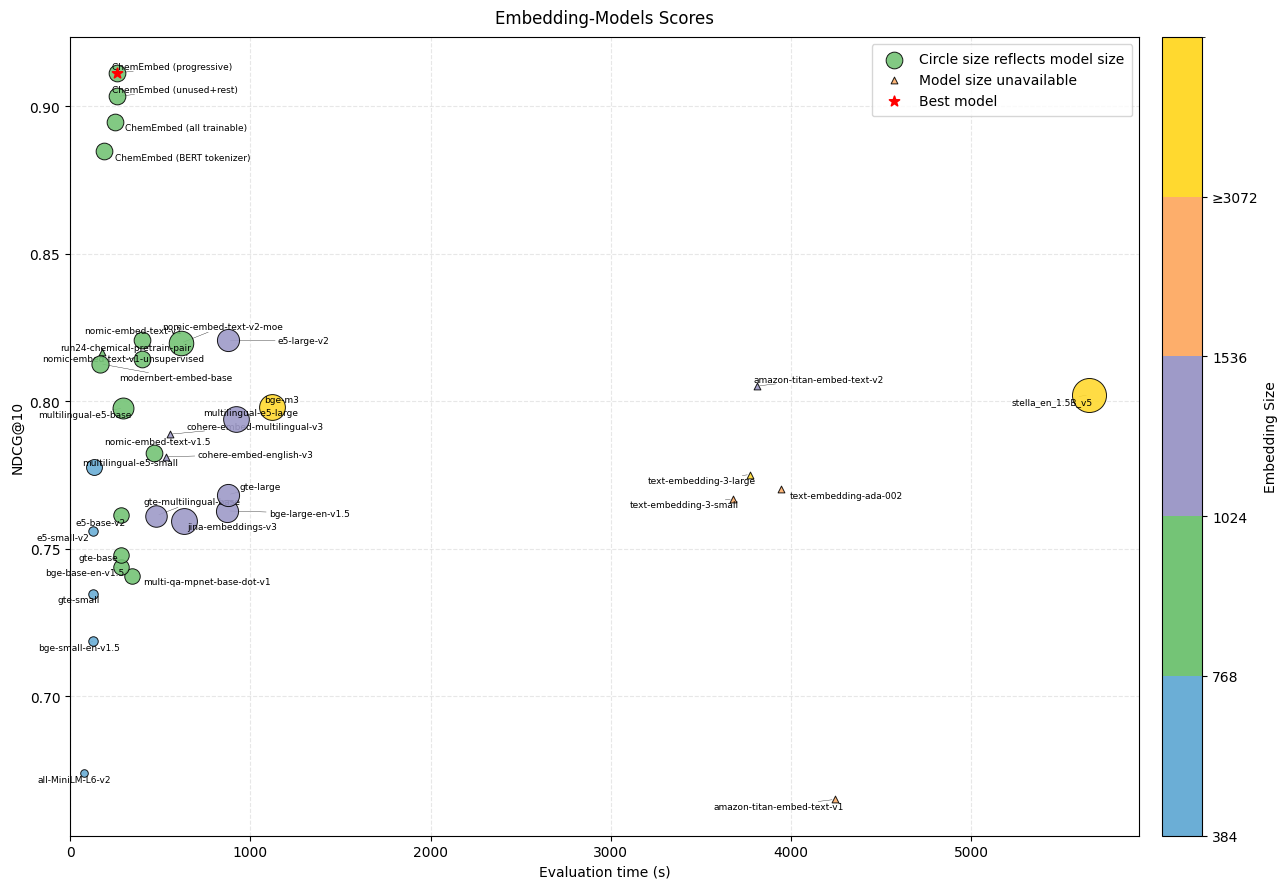

In [ ]:
plot_model_scatter(best_df_filtered, x_col="evaluation_time", y_col="score",title="Embedding-Models Scores",x_axis_label = "Evaluation time (Sample per sec)",y_axis_label = "NDCG@10",
                           embed_col= "embeding_dim",
        param_col  = "n_parameters",)